# Propagating Gradients Backwards
---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Propagating-Gradients-Backwards" data-toc-modified-id="Propagating-Gradients-Backwards-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Propagating Gradients Backwards</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Unit-Tests" data-toc-modified-id="Unit-Tests-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Unit Tests</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Normalize-Data" data-toc-modified-id="Normalize-Data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Normalize Data</a></span></li></ul></li><li><span><a href="#Backpropagation-from-scratch" data-toc-modified-id="Backpropagation-from-scratch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Backpropagation from scratch</a></span><ul class="toc-item"><li><span><a href="#Linear-Layer" data-toc-modified-id="Linear-Layer-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Linear Layer</a></span></li><li><span><a href="#Activation-Layer" data-toc-modified-id="Activation-Layer-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Activation Layer</a></span></li><li><span><a href="#Loss-Layer" data-toc-modified-id="Loss-Layer-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Loss Layer</a></span></li><li><span><a href="#Feedforward-Network" data-toc-modified-id="Feedforward-Network-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Feedforward Network</a></span></li></ul></li><li><span><a href="#Refactor-&amp;-Redesign" data-toc-modified-id="Refactor-&amp;-Redesign-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Refactor &amp; Redesign</a></span><ul class="toc-item"><li><span><a href="#Abstract-Layer-Class" data-toc-modified-id="Abstract-Layer-Class-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Abstract Layer Class</a></span></li><li><span><a href="#Linear-Layer" data-toc-modified-id="Linear-Layer-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear Layer</a></span></li><li><span><a href="#Activation-Layer" data-toc-modified-id="Activation-Layer-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Activation Layer</a></span></li><li><span><a href="#Loss-Layer" data-toc-modified-id="Loss-Layer-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Loss Layer</a></span></li><li><span><a href="#Feedforward-Network" data-toc-modified-id="Feedforward-Network-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Feedforward Network</a></span></li></ul></li><li><span><a href="#Comparison-with-PyTorch's-Autograd" data-toc-modified-id="Comparison-with-PyTorch's-Autograd-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparison with PyTorch's Autograd</a></span><ul class="toc-item"><li><span><a href="#PyTorch's-Performance" data-toc-modified-id="PyTorch's-Performance-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>PyTorch's Performance</a></span></li><li><span><a href="#Our-Model's-Performance" data-toc-modified-id="Our-Model's-Performance-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Our Model's Performance</a></span></li></ul></li></ul></div>

## Import Libraries

In [1]:
import math
import operator

import torch
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline

## Unit Tests

In [2]:
def test(a, b, compare, compare_name=None):
    if compare_name is None:
        compare_name = compare.__name__
    assert compare(a, b),\
    f"{compare_name} check failed:\n{a}\n{b}"

def test_zero(x, tol=1e-3):
    test(x, tol, operator.le, f"Zero (less than tolerance: {tol})")
    
def test_equality(a, b):
    test(a, b, operator.eq, "Equality")

def test_approximately(a, b):
    allclose = partial(torch.allclose, atol=1e-5, rtol=1e-03)
    if not isinstance(a, torch.Tensor) or not isinstance(b, torch.Tensor):
        a = torch.tensor(a)
        b = torch.tensor(b)
    test(a, b, allclose, "Approximate Equality")

## Load Data

In [3]:
dataset = MNIST(root="../data/")

In [4]:
x, y = dataset.data.float(), dataset.targets
x_train, x_test = x[:50000], x[50000:]
y_train, y_test = y[:50000], y[50000:]

x_train.shape, x_test.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

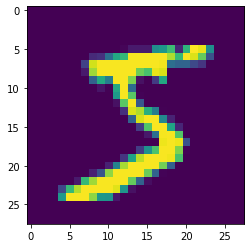

In [5]:
plt.imshow(x_train[0])

**Flatten**

In [6]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

In [7]:
n, m = x_train.shape
c = (y_train.max() - y_train.min()).item()
n, m, c

(50000, 784, 9)

## Normalize Data

In [8]:
def normalize(x, mean, std): return (x-mean)/std

In [9]:
train_mean = x_train.mean()
train_std = x_train.std()

In [10]:
x_train = normalize(x_train, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)

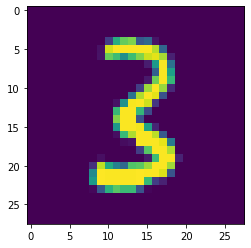

In [11]:
plt.imshow(x_test[0].view(28,28))

# Backpropagation from scratch

## Linear Layer

In [12]:
class Linear():
    '''Affine layer with weight and bias initialized using Kaiming initialization'''
    def __init__(self, in_size, out_size):
        self.weight = torch.randn(in_size, out_size) * math.sqrt(2/in_size)
        self.bias = torch.zeros(out_size)
    
    def __repr__(self):
        return f"(Linear: in={self.weight.shape[0]} out={self.weight.shape[1]})"
        
    def forward(self, x):
        self.x = x
        self.y = self.x@self.weight + self.bias 
        return self.y
    
    def backward(self):
        self.weight.g = self.x.t() @ self.y.g 
        self.bias.g = self.y.g
        self.x.g = self.y.g @ self.weight.t()

## Activation Layer

In [13]:
class ReLU():
    '''Rectified Linear Unit Layer'''
    
    def __init__(self, shift=0.):
        self.shift = shift
    
    def __repr__(self):
        return f"(ReLU: shift={self.shift})"
    
    def forward(self, x):
        self.x = x
        self.y = self.x.clamp_min(0.) - self.shift 
        return self.y
    
    def backward(self):
        self.x.g = self.y.g * (self.x>0).float()

## Loss Layer

In [14]:
class MSE():
    '''Mean Squared Error Layer'''
    
    def __repr__(self):
        return "Loss: Mean Squared Error"
    
    def forward(self, y_pred, y_true):
        self.x1 = y_pred
        self.x2 = y_true
        self.y = (self.x1-self.x2).pow(2).mean() 
        return self.y
    
    def backward(self):
        self.x1.g = 2 * (self.x1-self.x2) / self.x1.shape[0]

## Feedforward Network

In [15]:
class FeedForwardNN():
    '''Feedforward neural network'''

    def __init__(self, x_dim, y_dim, n_layers):
        # get an exponentially spaced array of layer dimensions
        def _exp(pos): return math.ceil(x_dim * (y_dim/x_dim)**pos)
        layer_dims  = [_exp(pos/n_layers) for pos in range(0, n_layers+1)]
        # construct the list of layers
        self.layers = []
        for i in range(n_layers):
            in_dim, out_dim = layer_dims[i], layer_dims[i+1]
            self.layers.append(Linear(in_dim, out_dim))
            self.layers.append(ReLU())
        self.loss = MSE()
        
    def __repr__(self):
        model_str = "\n".join(l.__repr__() for l in self.layers)
        model_str += "\n" + self.loss.__repr__()
        return model_str
    
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self):
        self.loss.backward()
        for layer in reversed(self.layers):
            layer.backward()

In [16]:
model = FeedForwardNN(x_dim=784, y_dim=1, n_layers=5)
model

(Linear: in=784 out=207)
(ReLU: shift=0.0)
(Linear: in=207 out=55)
(ReLU: shift=0.0)
(Linear: in=55 out=15)
(ReLU: shift=0.0)
(Linear: in=15 out=4)
(ReLU: shift=0.0)
(Linear: in=4 out=1)
(ReLU: shift=0.0)
Loss: Mean Squared Error

In [17]:
y_pred = model.forward(x_train)
loss = model.loss.forward(y_pred.float(), y_train.unsqueeze(-1).float())
model.backward()

# Refactor & Redesign

## Abstract Layer Class

In [18]:
class Layer():
    '''Abstract Layer class like PyTorch's nn.Module'''
    
    def __call__(self, *args):
        self.args = args
        self.y = self.forward(*self.args)
        return self.y

    def __repr__(self):
        raise NotImplementedError("__repr__ method not implemented")

    def forward(self, *args):
        raise NotImplementedError("forward method not implemented")
        
    def backward(self):
        raise NotImplementedError("backward method not implemented")

## Linear Layer

In [19]:
class Linear(Layer):
    '''Affine layer with weight and bias initialized using Kaiming initialization'''
    def __init__(self, in_size, out_size):
        self.weight = torch.randn(in_size, out_size) * math.sqrt(2/in_size)
        self.bias = torch.zeros(out_size)
    
    def __repr__(self):
        return f"(Linear: in={self.weight.shape[0]} out={self.weight.shape[1]})"
        
    def forward(self, x):
        return x@self.weight + self.bias 
    
    def backward(self):
        self.weight.g = self.args[0].t() @ self.y.g 
        self.bias.g = self.y.g
        self.args[0].g = self.y.g @ self.weight.t()

## Activation Layer

In [20]:
class ReLU(Layer):
    '''Rectified Linear Unit Layer'''
    
    def __init__(self, shift=0.):
        self.shift = shift
    
    def __repr__(self):
        return f"(ReLU: shift={self.shift})"
    
    def forward(self, x):
        return x.clamp_min(0.) - self.shift
    
    def backward(self):
        self.args[0].g = self.y.g * (self.args[0]>0).float()

## Loss Layer

In [21]:
class MSE(Layer):
    '''Mean Squared Error Layer'''
    
    def __repr__(self):
        return "Loss: Mean Squared Error"
    
    def forward(self, y_pred, y_true):
        return (y_pred-y_true).pow(2).mean()
    
    def backward(self):
        n = self.args[0].shape[0]
        self.args[0].g = 2 * (self.args[0] - self.args[1]) / n

## Feedforward Network

In [22]:
class FeedForwardNN(Layer):
    '''Feedforward neural network'''

    def __init__(self, x_dim, y_dim, n_layers):
        # get an exponentially spaced array of layer dimensions
        def _exp(pos): return math.ceil(x_dim * (y_dim/x_dim)**pos)
        layer_dims  = [_exp(pos/n_layers) for pos in range(0, n_layers+1)]
        # construct the list of layers
        self.layers = []
        for i in range(n_layers):
            in_dim, out_dim = layer_dims[i], layer_dims[i+1]
            self.layers.append(Linear(in_dim, out_dim))
            self.layers.append(ReLU())
        self.loss = MSE()
            
    def __repr__(self):
        model_str = "\n".join(l.__repr__() for l in self.layers)
        model_str += "\n" + self.loss.__repr__()
        return model_str
    
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def backward(self):
        self.loss.backward()
        for layer in reversed(self.layers):
            layer.backward()

In [23]:
model = FeedForwardNN(x_dim=784, y_dim=1, n_layers=5)
model

(Linear: in=784 out=207)
(ReLU: shift=0.0)
(Linear: in=207 out=55)
(ReLU: shift=0.0)
(Linear: in=55 out=15)
(ReLU: shift=0.0)
(Linear: in=15 out=4)
(ReLU: shift=0.0)
(Linear: in=4 out=1)
(ReLU: shift=0.0)
Loss: Mean Squared Error

In [24]:
y_pred = model(x_train)
loss = model.loss(y_pred.float(), y_train.unsqueeze(-1).float())
model.backward()

# Comparison with PyTorch's Autograd

In [25]:
import timeit
from functools import partial
from torch import nn

In [26]:
torch.manual_seed(42)

## PyTorch's Performance

In [27]:
class TorchModel(nn.Module):
    
    def __init__(self, x_dim, h_dim, y_dim):
        super().__init__()
        self.layers = [nn.Linear(x_dim, h_dim),
                       nn.ReLU(),
                       nn.Linear(h_dim,y_dim)]
        self.loss = nn.MSELoss()

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [28]:
torch_model = TorchModel(784, 400, 1)

In [29]:
torch_forward = timeit.timeit(partial(torch_model,x_train), number=10)
y_pred = torch_model(x_train)
loss = torch_model.loss(y_pred, y_train.unsqueeze(-1).float())
torch_backward = timeit.timeit(loss.backward, number=1)

In [30]:
torch_forward, torch_backward

(1.3273273869999684, 0.23294704500040098)

## Our Model's Performance

In [31]:
class OurModel(Layer):
    
    def __init__(self, x_dim, h_dim, y_dim):
        self.layers = [Linear(x_dim, h_dim),
                       ReLU(),
                       Linear(h_dim, y_dim)]
        self.loss = MSE()
    
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def backward(self):
        self.loss.backward()
        for layer in reversed(self.layers):
            layer.backward()

In [32]:
model = OurModel(784, 400, 1)

In [33]:
forward = timeit.timeit(partial(model,x_train), number=10)
y_pred = model(x_train)
loss = model.loss(y_pred, y_train.unsqueeze(-1).float())
backward = timeit.timeit(model.backward, number=1)

In [34]:
forward, backward

(1.7871809229991413, 0.2806604300003528)

**TODO**:
* [ ] Write a reproducible test for correctness of gradient calculation    

___